In [18]:
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
import json
from functools import partial
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

import nomad.io.base as loader
import nomad.stop_detection.utils as utils
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.dbscan as TADBSCAN
import nomad.stop_detection.grid_based as GRID_BASED # for oracle visits
import nomad.stop_detection.postprocessing as pp

import nomad.visit_attribution.visit_attribution as visits
import nomad.filters as filters
import nomad.city_gen as cg

from nomad.contact_estimation import compute_stop_detection_metrics

In [19]:
def classify_dwell(duration):
    if duration < 60:
        return 'low'
    elif 60 <= duration <= 180:
        return 'mid'
    else:
        return 'high'

def classify_size(size):
    if size == 1:
        return 'small'
    elif 2 <= size <= 4:
        return 'medium'
    else:
        return 'big'

## Configure stop detection algorithms

In [20]:
with open('config_low_ha.json', 'r', encoding='utf-8') as f:
    config1 = json.load(f)

with open('config_high_ha.json', 'r', encoding='utf-8') as f:
    config2 = json.load(f)

config=config1

In [26]:
config["algos"] = {
    "ta_dbscan_coarse":{
        "func":TADBSCAN.ta_dbscan,
        "params":{
            "time_thresh":240,
            "dist_thresh":15,
            "min_pts":2
        }
    },
    "lachesis_coarse":{
        "func":LACHESIS.lachesis,
        "params":{
            'dt_max': 240,
            'delta_roam': 20
        }
    }
}

## Load sparse data and diaries

In [27]:
poi_table = gpd.read_file('../../garden_city.gpkg').rename(columns={"building_id":"location"})

sparse_path=config["output_files"]["sparse_path"]
diaries_path=config["output_files"]["diaries_path"]
homes_path=config["output_files"]["homes_path"]

sparse_df = loader.from_file(sparse_path, format="parquet")
diaries_df = loader.from_file(diaries_path, format="parquet").rename(columns={"identifier":"user_id"})
homes_df = pd.read_parquet(homes_path)

mask = ~diaries_df.location.isna()
diaries_df.loc[mask,'dwell_length'] = diaries_df.loc[mask,'duration'].apply(classify_dwell)
diaries_df.loc[mask,'building_size'] = diaries_df.loc[mask,'size'].apply(classify_size)

In [ ]:
q = filters.completeness(sparse_df,
             periods=30,
             freq="min").to_frame(name="q_stat").reset_index()

plt.figure(figsize=(4,3))
ax = sns.kdeplot(
    data=q,
    x="q_stat",
    fill=True,
    linewidth=1.5,
    bw_adjust=1.3,
    cut=0
)

# cosmetics
ax.set_xlabel("q (Trajectory Completeness)")
ax.set_ylabel("Density")
ax.grid(True, alpha=0.3)
sns.despine(top=True, right=True)

# annotation (top-right corner in axes coords)
ax.text(
    0.99, 0.95,
    f"N = {len(q)}",
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=9
)

plt.tight_layout()
plt.show(block=False)
plt.close()

## Stop detection

In [28]:
results_list = []
for user in tqdm(diaries_df.user_id.unique(), desc='Processing users'):
    sparse = sparse_df.query("user_id==@user").copy()
    truth = diaries_df.query("user_id==@user").copy()
    
    # Run both algorithms
    for algo_name, algo_config in config["algos"].items():
        # Run stop detection
        stops = algo_config["func"](sparse, **algo_config["params"], x="x", y="y")
        
        # Map stops to buildings
        stops["location"] = visits.point_in_polygon(
            stops, 
            poi_table=poi_table, 
            data_crs='EPSG:3857',
            max_distance=10, 
            location_id='location', 
            x='x', 
            y='y'
        )
        
        # Compute metrics
        metrics = compute_stop_detection_metrics(
            stops=stops,
            truth=truth,
            user_id=user,
            algorithm=algo_name,
            traj_cols={'location_id': 'location'}  
        )
        
        results_list.append(metrics)

# Convert to DataFrame
results_df = pd.DataFrame(results_list)

# Join with beta_ping from homes_df
results_df = results_df.merge(
    homes_df[['user_id', 'beta_ping']], 
    on='user_id', 
    how='left'
)

print(f"Computed metrics for {len(results_df)} user-algorithm combinations")
print(results_df.head())

Processing users: 100%|████████████████████████████████████████████████████████████| 3000/3000 [04:30<00:00, 11.09it/s]


Computed metrics for 6000 user-algorithm combinations
   precision    recall        f1  missed_fraction  merged_fraction  \
0   0.590278  0.357143  0.445026             0.25         0.333333   
1   0.629630  0.357143  0.455764             0.25         0.333333   
2   0.675824  0.512500  0.582938             0.25         0.333333   
3   1.000000  0.570833  0.726790             0.25         0.000000   
4   0.517442  0.373950  0.434146             0.00         0.500000   

   split_fraction               user_id         algorithm  beta_ping  
0        0.000000  admiring_ardinghelli  ta_dbscan_coarse  14.641026  
1        0.500000  admiring_ardinghelli   lachesis_coarse  14.641026  
2        0.000000       admiring_austin  ta_dbscan_coarse   8.307692  
3        0.333333       admiring_austin   lachesis_coarse   8.307692  
4        0.000000        admiring_bassi  ta_dbscan_coarse   9.769231  


# Plots

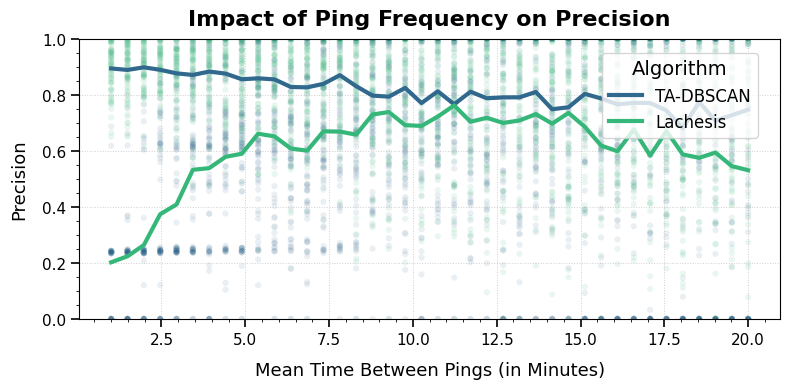

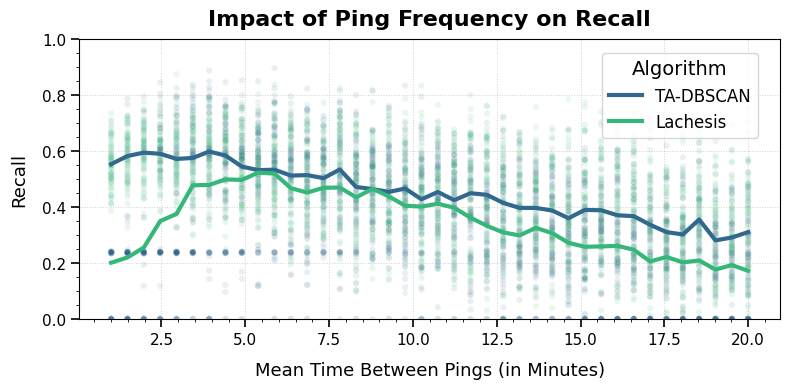

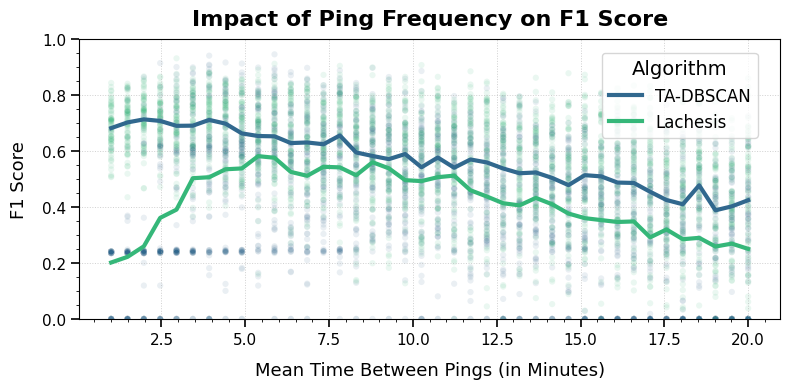

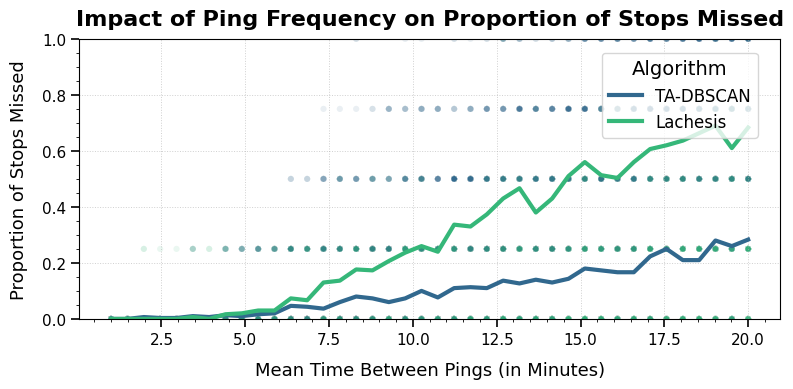

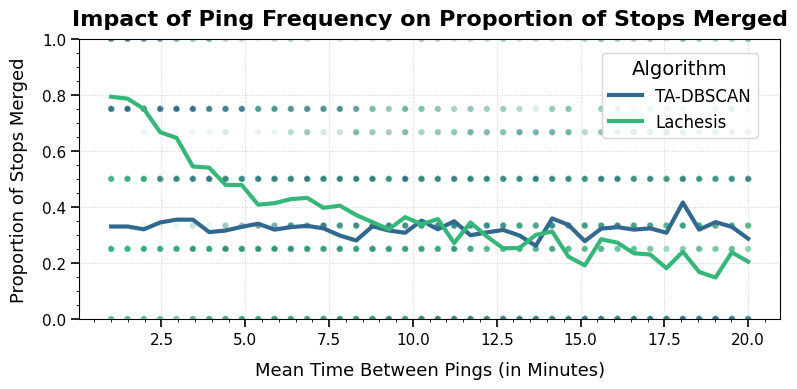

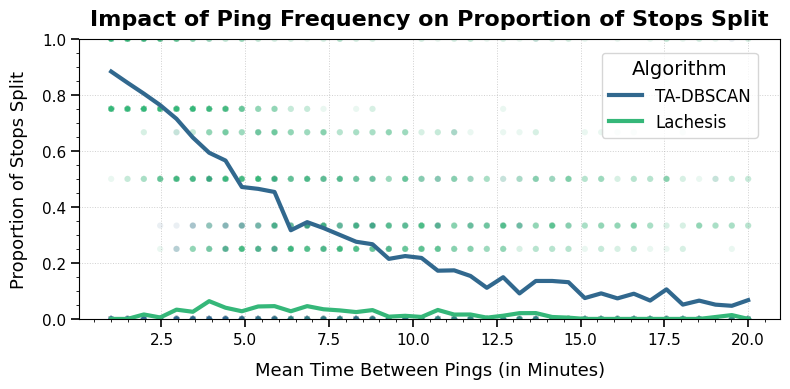

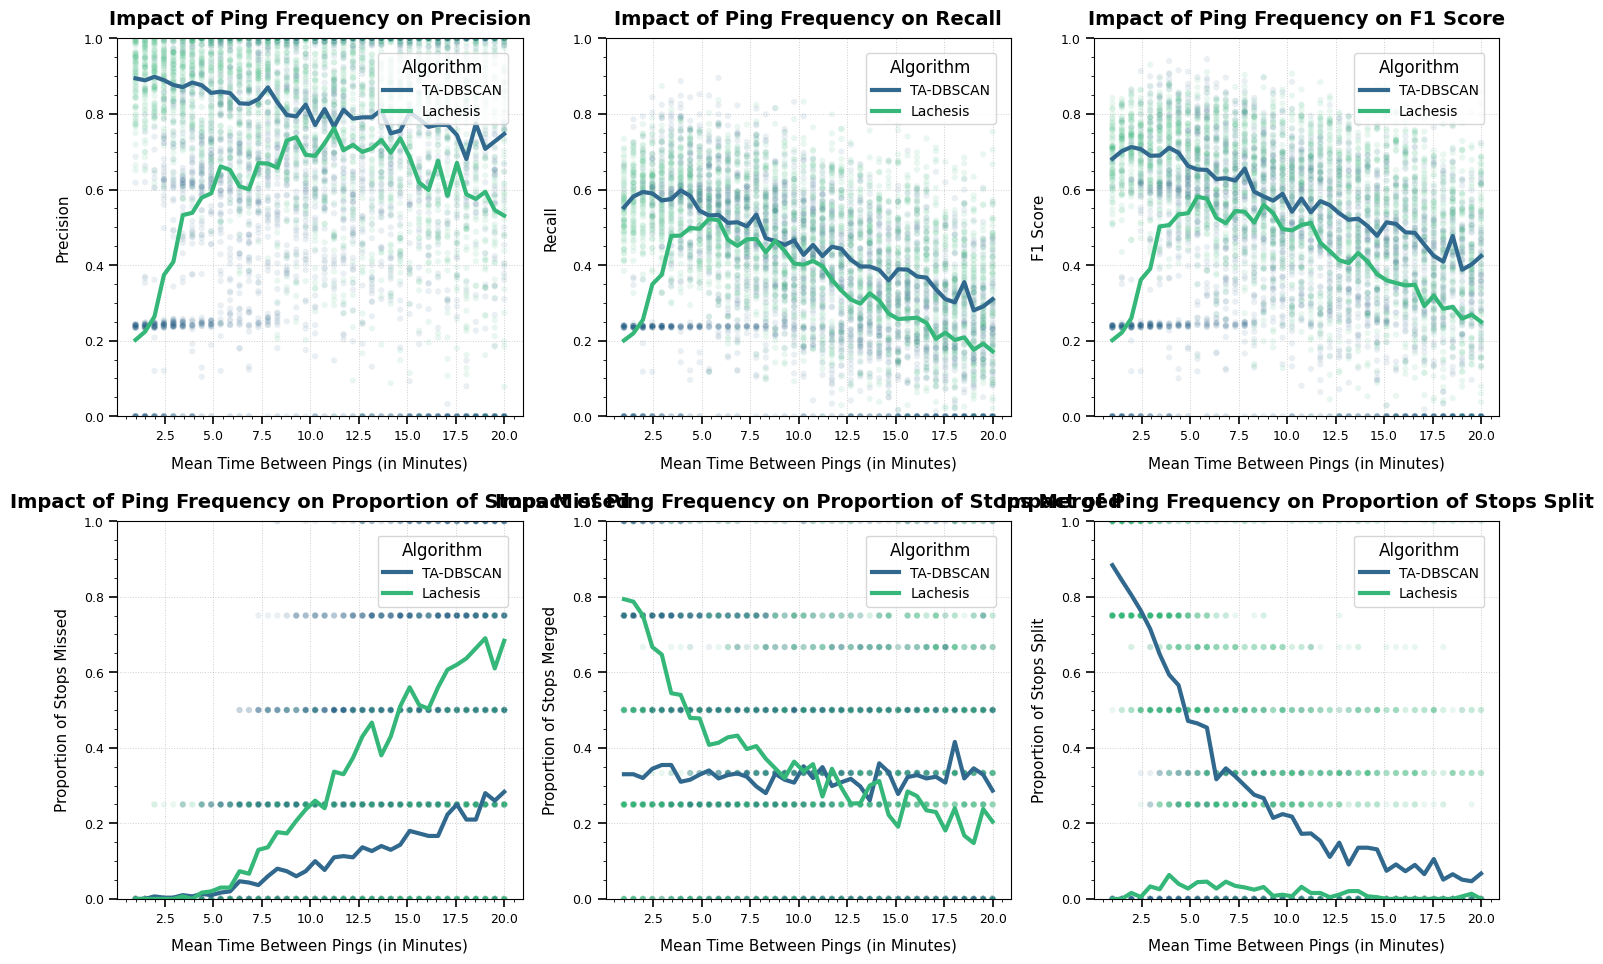

In [29]:
import os
os.makedirs('figures', exist_ok=True)

def plot_metric(metric, title, ax=None, save_individual=True):
    """Plot a single metric with consistent styling."""
    chart_df = results_df.groupby(['beta_ping', 'algorithm'])[metric].agg(['mean', 'sem']).reset_index()
    chart_df.rename(columns={'mean': f'{metric}_mean'}, inplace=True)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
        is_individual = True
    else:
        is_individual = False
    
    # Add scatter plot background (individual data points)
    sns.scatterplot(data=results_df, x='beta_ping', y=metric, hue='algorithm',
                   alpha=0.1, s=20, ax=ax, palette='viridis', legend=False)
    
    # Add line plot (mean values) - this will create the legend
    line_plot = sns.lineplot(data=chart_df, x='beta_ping', y=f'{metric}_mean', hue='algorithm',
                            marker='', linewidth=3, ax=ax, palette='viridis')
    
    # Styling
    font_sizes = {'labels': 15 if is_individual else 13, 'legend': 12 if is_individual else 10}
    ax.set_xlabel('Mean Time Between Pings (in Minutes)', fontsize=font_sizes['labels'], labelpad=10)
    ax.set_ylabel(title, fontsize=font_sizes['labels'], labelpad=10)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle=':', alpha=0.6, linewidth=0.7)
    ax.tick_params(axis='both', which='major', labelsize=font_sizes['labels']-2, length=6, width=1.2)
    ax.minorticks_on()
    
    # Fix legend to show lines instead of dots
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['TA-DBSCAN', 'Lachesis'], title='Algorithm', bbox_to_anchor=(0.98, 0.98), 
              loc='upper right', fontsize=font_sizes['legend'], title_fontsize=font_sizes['legend']+2, frameon=True)
    
    if is_individual and save_individual:
        plt.tight_layout()
        plt.savefig(f"figures/exp1_{metric}.svg", bbox_inches='tight')
        plt.savefig(f"figures/exp1_{metric}.png", dpi=600, bbox_inches='tight')
        plt.show(block=False)
        plt.close()

# Individual plots
metrics = {
    'precision': 'Precision', 'recall': 'Recall', 'f1': 'F1 Score',
    'missed_fraction': 'Proportion of Stops Missed',
    'merged_fraction': 'Proportion of Stops Merged', 
    'split_fraction': 'Proportion of Stops Split'
}

for metric, title in metrics.items():
    plot_metric(metric, title)

# Grid plot with better spacing
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, (metric, title) in enumerate(metrics.items()):
    plot_metric(metric, title, ax=axes.flat[i], save_individual=False)
plt.tight_layout(pad=2.0, h_pad=1.5, w_pad=1.5)
plt.savefig("figures/exp1_all_metrics_grid.svg", bbox_inches='tight')
plt.savefig("figures/exp1_all_metrics_grid.png", dpi=600, bbox_inches='tight')
plt.show(block=False)
plt.close()